In [ ]:
!pip install simfin

## Data Import and Cleaning

In [ ]:
# Imports
import simfin as sf
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

from simfin.names import *

In [ ]:
# API Setup
sf.set_api_key('free')

# Set the local directory where data-files are stored.
# The dir will be created if it does not already exist.
sf.set_data_dir('~/simfin_data/')

In [ ]:
# StockHub creation from API
market = 'us'
offset = pd.DateOffset(days=90)

# StockHub object with useful features and functions
hub = sf.StockHub(market='us',offset=offset, refresh_days=30, refresh_days_shareprices=10)

In [ ]:
# Calculating various signals using the StockHub object
# Putting them in DataFrame for usage

# Creates daily data points for same dates as share prices
signal_variant = 'daily'

# Financial signals
df_fin_sig = hub.fin_signals(variant=signal_variant)
# Growth signals
df_growth_sig = hub.growth_signals(variant=signal_variant)
# Valuation signals
df_val_sig = hub.val_signals(variant=signal_variant)

# Concatenate data frames
dfs = [df_fin_sig, df_growth_sig, df_val_sig]
df_sig = pd.concat(dfs, axis=1)

Dataset "us-income-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!
Cache-file 'fin_signals-e9b3aeb2.pickle' on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-income-quarterly" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-balance-quarterly" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" on disk (0 days old).
- Loading from disk ... Done!
Cache-file 'growth_signals-e9b3aeb2.pickle' on disk (0 days old).
- Loading from disk ... Done!
Cache-file 'val_signals-9f3839e5.pickle' on disk (0 days old).
- Loading from disk ... Done!


In [ ]:
"""
# Removing all NaN rows
print(df_sig.shape)
df_sig = df_sig.dropna(how='all')
print(df_sig.shape)
"""

"\n# Removing all NaN rows\nprint(df_sig.shape)\ndf_sig = df_sig.dropna(how='all')\nprint(df_sig.shape)\n"

In [ ]:
# Looking at the resulting DataFrame of signals
df_sig.head()

(Dividends + Share Buyback) / FCF  ...  Price to Book Value
Ticker Date                                           ...                     
A      2007-01-03                                NaN  ...                  NaN
       2007-01-04                                NaN  ...                  NaN
       2007-01-05                                NaN  ...                  NaN
       2007-01-08                                NaN  ...                  NaN
       2007-01-09                                NaN  ...                  NaN

[5 rows x 42 columns]

In [ ]:
"""
# Lots of data is missing/NaN so want to clean it
col_before = df_sig.columns
print(df_sig.shape)

# Removing data that isn't at least half filled in
threshold = 0.9*len(df_sig.dropna(how='all'))
df_sig_new = df_sig.dropna(axis='columns', thresh=threshold)

col_after = df_sig_new.columns

print(df_sig_new.shape)
"""

"\n# Lots of data is missing/NaN so want to clean it\ncol_before = df_sig.columns\nprint(df_sig.shape)\n\n# Removing data that isn't at least half filled in\nthreshold = 0.9*len(df_sig.dropna(how='all'))\ndf_sig_new = df_sig.dropna(axis='columns', thresh=threshold)\n\ncol_after = df_sig_new.columns\n\nprint(df_sig_new.shape)\n"

In [ ]:
"""
# Removed columns are:
print(col_before.difference(col_after))
"""

'\n# Removed columns are:\nprint(col_before.difference(col_after))\n'

In [ ]:
# Calculating 1-3 year returns from the given data
df_returns = hub.mean_log_returns(name="Total Return 1-3 Years", 
                                  future=True, annualized=True, 
                                  min_years=1, max_years=3)

Cache-file 'mean_log_change-222275e4.pickle' on disk (0 days old).
- Loading from disk ... Done!


In [ ]:
# Looks like some values are NaN
# Probably need to get rid of them later
print(df_returns)

Ticker  Date      
A       2007-01-03   -0.147197
        2007-01-04   -0.149252
        2007-01-05   -0.144586
        2007-01-08   -0.143051
        2007-01-09   -0.144199
                        ...   
ZYXI    2019-12-02         NaN
        2019-12-03         NaN
        2019-12-04         NaN
        2019-12-05         NaN
        2019-12-06         NaN
Name: Total Return 1-3 Years, Length: 5706725, dtype: float64


In [ ]:
# Combining returns with dataset
# have to use original dataset to match the rows
dfs = [df_sig, df_returns]
df_sig_ret = pd.concat(dfs, axis=1)

In [ ]:
# Removing data that isn't at least half filled in
print(df_sig_ret.shape)
col_before = df_sig_ret.columns
threshold = 0.9*len(df_sig.dropna(how='all'))
df_sig_ret = df_sig_ret.dropna(axis='columns', thresh=threshold)

print(df_sig_ret.shape)
col_after = df_sig_ret.columns

# Lots of data is missing/NaN so want to clean it
# Removing all NaN rows
df_sig_ret = df_sig_ret.dropna(how='any')
print(df_sig_ret.shape)



# Removed columns are:
print(col_before.difference(col_after))

(5706725, 43)
(5706725, 27)
(1781405, 27)
Index(['Assets Growth', 'Assets Growth YOY', 'Debt Ratio', 'Dividend Yield',
       'Earnings Growth', 'Earnings Growth YOY', 'FCF Growth',
       'FCF Growth YOY', 'Interest Coverage', 'Inventory Turnover',
       'Net Acquisitions / Total Assets', 'R&D / Gross Profit',
       'R&D / Revenue', 'Return on Research Capital', 'Sales Growth',
       'Sales Growth YOY'],
      dtype='object')


In [ ]:
# Now removing companies which don't have at least 1000 data points
df_sig_ret = df_sig_ret.groupby(TICKER) \
                .filter(lambda df: len(df)>1000)
print(df_sig_ret.shape)

(1549188, 27)


In [ ]:
# "Winorize" the data which caps at 5% and 95% values
df_sig_ret = sf.winsorize(df_sig_ret)

In [ ]:
# Data is now finally cleaned enough for analysis
print(df_sig_ret.shape)

(1549188, 27)


## Machine Learning

In [ ]:
# Split training and test data
# Doing it by ticker
tickers = df_sig_ret.reset_index()[TICKER].unique()
print(tickers)

tickers_train, tickers_test = train_test_split(tickers, train_size=.8)
#print(tickers_train)
#print(tickers_test)

['A' 'AAON' 'AAP' ... 'ZEUS' 'ZGNX' 'ZMH']


In [ ]:
# Too much data, need to reduce it
np.random.seed(0)
tickers_train = np.random.choice(tickers_train, 40, replace=False)
tickers_test = np.random.choice(tickers_test, 3, replace=False)

print(tickers_train)
print(tickers_test)

['MCK' 'FDS' 'AAWW' 'VRSN' 'FLXS' 'AWX' 'BLDR' 'ORCL' 'WWE' 'ULBI' 'MIND'
 'MELI' 'KMI' 'USM' 'SNPS' 'IAC' 'HP' 'ULTA' 'MYGN' 'COG' 'HNI' 'PETS'
 'UDR' 'IAIC' 'MDRX' 'RECN' 'TPX' 'STLD' 'PRLB' 'SPB' 'AAON' 'SCSS' 'USAP'
 'EXP' 'CHRW' 'PG' 'IT' 'RMD' 'BREW' 'OCC']
['OTEX' 'LMT' 'RTN']


In [ ]:
# The values above were only tickers, did not contain all the data
df_train = df_sig_ret.loc[tickers_train]
df_test = df_sig_ret.loc[tickers_test]
print(df_train.shape)
print(df_test.shape)

(56477, 27)
(5308, 27)


In [ ]:
# Splitting data frame into X and y frames
X_train = df_train.drop(columns=["Total Return 1-3 Years"])
X_test = df_test.drop(columns=["Total Return 1-3 Years"])

y_train = df_train["Total Return 1-3 Years"]
y_test = df_test["Total Return 1-3 Years"]

print(X_train.shape, "and", y_train.shape)
print(X_test.shape, "and", y_test.shape)


(56477, 26) and (56477,)
(5308, 26) and (5308,)


In [ ]:
# Using actual machine learning algorithm as selected
# Using the SVR - Support Vector Regression

# Training values
model = SVR(C=1.0, kernel='rbf',gamma='auto')
model.fit(X_train, y_train)
#y_train_predict = model.predict(x_train)
model.score(X_train, y_train)

-2173.3991743855063

In [ ]:
# Plotting HP and PG stock returns predicted vs actual

# First getting the relevant values form the DataFrame and predicting
df_y_train = pd.DataFrame(y_train)
df_X_train = pd.DataFrame(X_train)

# Indexing relevant values
df_y_HP = df_y_train.loc["HP"]
df_y_PG = df_y_train.loc["KMI"]
df_X_HP = df_X_train.loc["HP"]
df_X_PG = df_X_train.loc["KMI"]

# Predicting
df_y_HP_pred = model.predict(df_X_HP)
df_y_PG_pred = model.predict(df_X_PG)

# Adding to original df
df_y_HP['Predicted Return'] = df_y_HP_pred
df_y_PG['Predicted Return'] = df_y_PG_pred


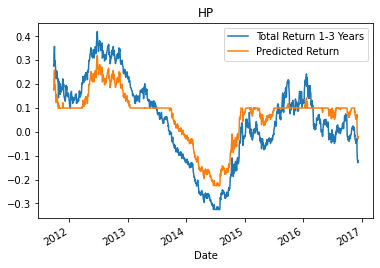

In [ ]:
# Plotting HP
_ = df_y_HP.plot(title="HP")

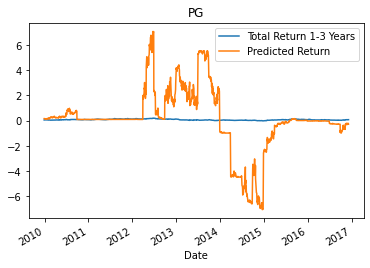

In [ ]:
# Plotting PG
_ = df_y_PG.plot(title="PG")

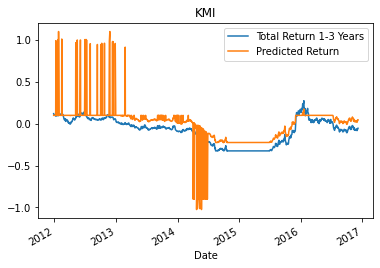

In [ ]:
# Plotting KMI
_ = df_y_PG.plot(title="KMI")

In [ ]:
# Getting AAPL and MSFT for validating training data
df_AAPL = df_sig_ret.loc["AAPL"]
df_TJX = df_sig_ret.loc["TJX"]

df_X_AAPL = pd.DataFrame(df_AAPL.drop(columns=["Total Return 1-3 Years"]))
df_X_TJX = pd.DataFrame(df_TJX.drop(columns=["Total Return 1-3 Years"]))

df_y_AAPL = pd.DataFrame(df_AAPL["Total Return 1-3 Years"])
df_y_TJX = pd.DataFrame(df_TJX["Total Return 1-3 Years"])


# Predicting
df_y_AAPL_pred = model.predict(df_X_AAPL)
df_y_TJX_pred = model.predict(df_X_TJX)


# Adding to original df
df_y_AAPL['Predicted Return'] = df_y_AAPL_pred
df_y_TJX['Predicted Return'] = df_y_TJX_pred

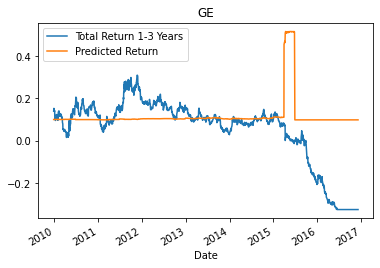

In [ ]:
# Plotting GE
#print(df_y_AAPL.columns)
_ = df_y_AAPL.plot(title="GE")

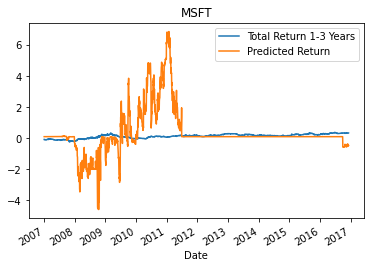

In [ ]:
# Plotting MSFT
_ = df_y_TJX.plot(title="MSFT")

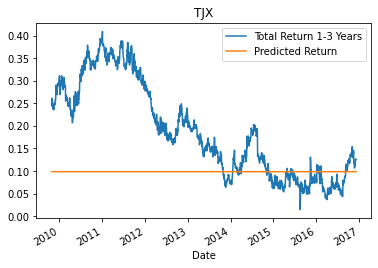

In [ ]:
# Plotting TJX
_ = df_y_TJX.plot(title="TJX")

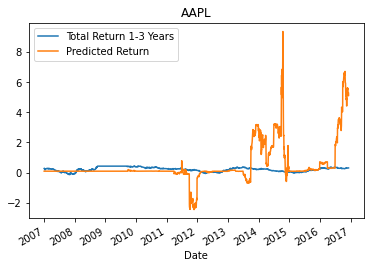

In [ ]:
# Plotting AAPL
_ = df_y_AAPL.plot(title="AAPL")

In [ ]:
print(df_y_AAPL)

Date
2007-01-03    0.278078
2007-01-04    0.265229
2007-01-05    0.269213
2007-01-08    0.266987
2007-01-09    0.222634
                ...   
2016-11-30    0.309225
2016-12-01    0.314699
2016-12-02    0.313016
2016-12-05    0.317487
2016-12-06    0.313716
Name: Total Return 1-3 Years, Length: 2501, dtype: float64


In [ ]:
# Plotting training results
#plt.figure()
#plt.title("Stock Returns Comparison")
#plt.xlabel("Date")
#plt.ylabel("Log-Mean Returns")
#plt.plot(range(0,len(x_train)), y_train, c='r')
#plt.plot(range(0,len(x_train)), train_predict, c='k')